# Squeezing More out of LIME
<br>
Creating aggregations of LIME values 
<br>
Dataset: https://archive.ics.uci.edu/ml/datasets/Abalone

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from lime.lime_tabular import LimeTabularExplainer

import shap
shap.initjs()

from sklearn.metrics import accuracy_score,confusion_matrix

import sys
sys.path.append('../')
import utils

## Dataset

In [2]:
#import dataset
data = pd.read_csv("../../data/abalone.data",
                  names=["sex","length","diameter","height","whole weight",
                         "shucked weight","viscera weight","shell weight","rings"])

data.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
y = data["rings"]
X = data[["sex", "length", "height", "shucked weight", "viscera weight", "shell weight"]]

#Create dummy variables
X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]
X['sex.I'] = [1 if s == 'I' else 0 for s in X['sex']]
X = X.drop('sex', axis=1)

X.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


## Train Model

In [4]:
# Train model
model = RandomForestRegressor()
model.fit(X, y)

RandomForestRegressor()

Text(0.5, 0, 'Actual')

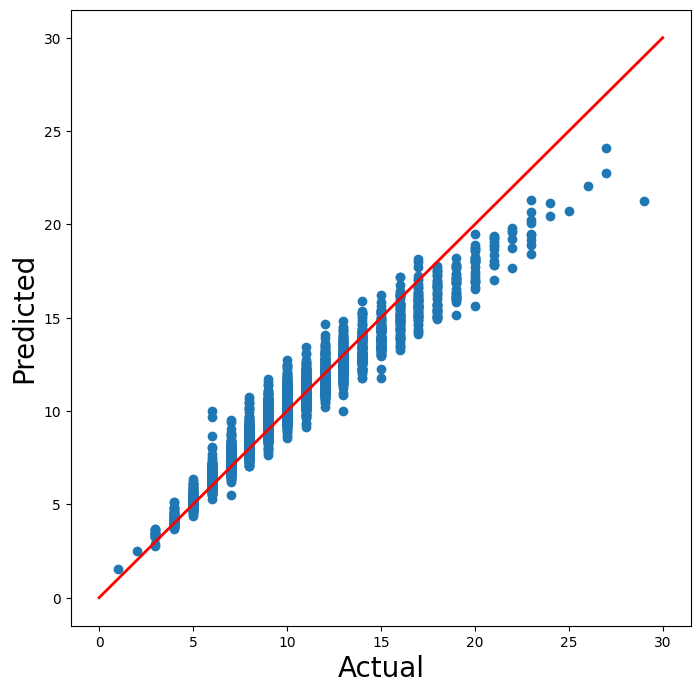

In [5]:
# Get predictions
y_pred = model.predict(X)

# Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(y,y_pred)
plt.plot([0, 30], [0, 30], color='r', linestyle='-', linewidth=2)

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

## LIME

In [14]:
# Create the explainer
explainer = LimeTabularExplainer(X.values, 
                                   feature_names=X.columns, 
                                   class_names=['rings'], 
                                   mode='regression',
                                   random_state=101)

In [15]:
# Get explanation for first row
exp = explainer.explain_instance(X.iloc[0], 
                                 model.predict, 
                                labels=X.columns)

#Display explanation
exp.show_in_notebook(show_table=True)

exp.save_to_file('explanation_1.html')

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [17]:
# Check calculations
exp_weight = [x[1] for x in exp.as_map()[1]]

print(np.mean(y_pred) + sum(exp_weight))
print(y_pred[0])

9.44127693562197
13.1


## Aggregate weights

In [19]:
def return_weights(exp):
    
    """Get weights from LIME explanation object"""
    
    exp_list = exp.as_map()[1]
    exp_list = sorted(exp_list, key=lambda x: x[0])
    exp_weight = [x[1] for x in exp_list]
    
    return exp_weight
    

In [20]:
weights = []

# Iterate over first 100 rows in feature matrix
for x in X.values[0:100]:
    
    # Get explanation
    exp = explainer.explain_instance(x, 
                                 model.predict, 
                                 num_features=10, 
                                labels=X.columns)
    
    # Get weights
    exp_weight = return_weights(exp)
    weights.append(exp_weight)
    
# Create DataFrame
lime_weights = pd.DataFrame(data=weights,columns=X.columns)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fit

In [21]:
print(len(lime_weights))
lime_weights.head()

100


,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.116618,-0.203584,0.723282,-0.051443,-1.297541,-0.009596,-0.065160,0.227258
1,0.353390,-0.300719,1.999708,-0.283149,-5.056232,0.076485,0.083960,0.018909
2,0.088994,-0.308048,0.898471,-0.169749,-1.415496,-0.124273,0.196173,0.067049
3,0.381634,-0.069249,0.902336,0.031439,-1.409221,-0.032303,0.041546,0.228708
4,0.341743,-0.307985,2.102684,-0.228401,-5.104406,-0.049211,-0.108880,-0.192840


In [23]:
np.shape(lime_weights)

(100, 8)


### Absolute Mean


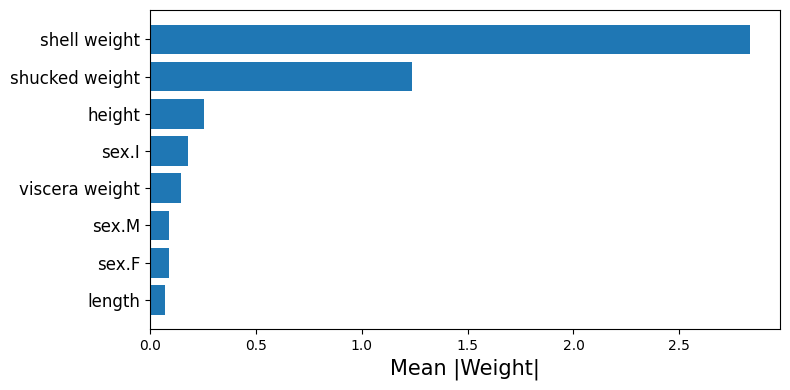

In [23]:
# Get abs mean of LIME weights
abs_mean = lime_weights.abs().mean(axis=0)
abs_mean = pd.DataFrame(data={'feature':abs_mean.index, 'abs_mean':abs_mean})
abs_mean = abs_mean.sort_values('abs_mean')

# Plot abs mean
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,4))

y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature

plt.barh(y=y_ticks,width=abs_mean.abs_mean,)
plt.yticks(ticks=y_ticks,labels=y_labels,size= 12)
plt.title('')
plt.ylabel('')
plt.xlabel('Mean |Weight|',size=15)

# Save figure
utils.save_fig("MA4_average_weights")

## Feature Trend

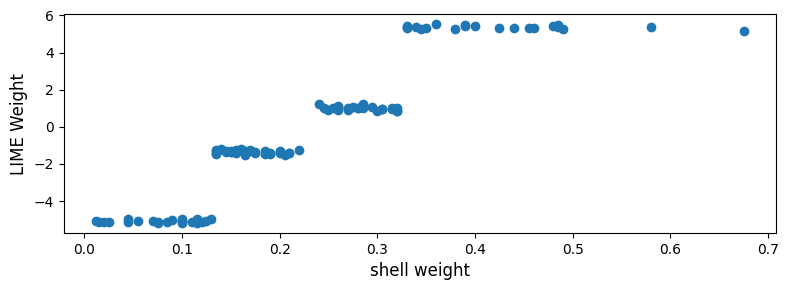

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,3))

# Get weights and feature values
feature_weigth = lime_weights['shell weight']
feature_value = X['shell weight'][0:100]

plt.scatter(x=feature_value ,y=feature_weigth)

plt.ylabel('LIME Weight',size=12)
plt.xlabel('shell weight',size=12)

# Save figure
utils.save_fig("MA4_scatter_weights")

## Beeswarm

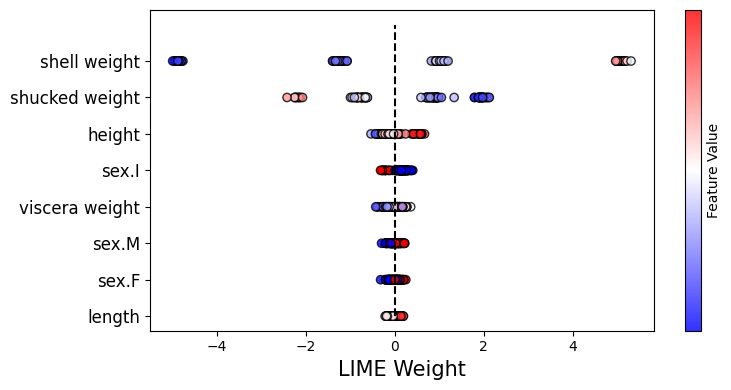

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,4))

y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature

# Plot scatterplot for each feature
for i,feature in enumerate(y_labels):
    
    feature_weigth = lime_weights[feature]
    feature_value = X[feature][0:100]
    
    plt.scatter(x=feature_weigth ,
                y=[i]*len(feature_weigth),
                c=feature_value,
                cmap='bwr',
                edgecolors='black',
               alpha=0.8)
    
plt.vlines(x=0,ymin=0,ymax=len(y_labels),colors='black',linestyles="--")
plt.colorbar(label='Feature Value',ticks=[])

plt.yticks(ticks=y_ticks,labels=y_labels,size=12)
plt.xlabel('LIME Weight',size=15)

# Save figure
utils.save_fig("MA4_lime_beeswarm")

## Using SHAP package

In [56]:
# Get SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X[0:100])

# Replace SHAP values with LIME weights
shap_placeholder = explainer(X[0:100])
shap_placeholder.values = np.array(lime_weights)

Text(0.5, 0, 'mean(|LIME weight|)')

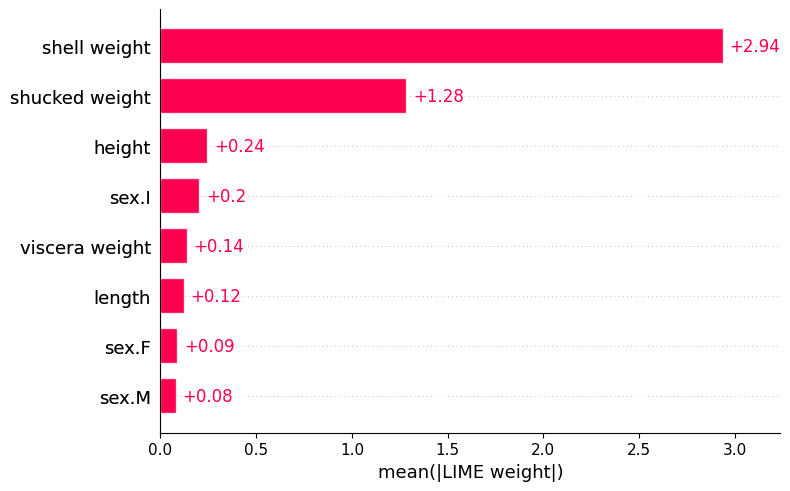

In [57]:
# Mean SHAP
shap.plots.bar(shap_placeholder,show=False)
plt.xlabel("mean(|LIME weight|)")

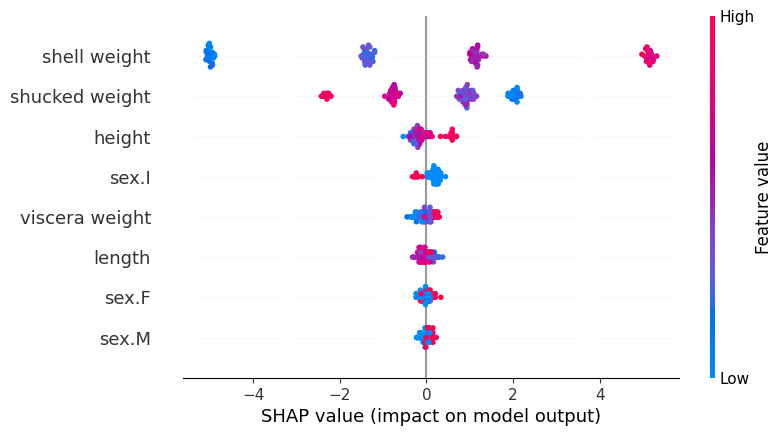

In [58]:
# Beeswarm plot using SHAP values
shap.plots.beeswarm(shap_placeholder,show=False)